# FW20 Breakout Trading System

## FW20 Futures

FW20 futures are standardized financial contracts traded on [the Warsaw Stock Exchange (GPW)](https://www.gpw.pl/en-home), where the underlying asset is the WIG20 index — a benchmark index representing the 20 largest companies on the Polish stock market.

### What Are FW20 Futures?

- FW20 stands for Futures on WIG20.
- These are cash-settled index futures, meaning there's no physical delivery of stocks—just a monetary settlement based on the index value.
- They allow investors to speculate, hedge, or gain leveraged exposure to the Polish equity market.

### Contract Specifications

- **Underlying asset**: WIG20 index
- **Multiplier**: 20 PLN per index point → If the contract is priced at 2,000 points, its nominal value is 40,000 PLN.
- **Settlement**: Cash only, no delivery of shares
- **Expiration months**: March, June, September, December (quarterly cycle)
- **Last trading day**: Third Friday of the expiration month (or the prior session if Friday is a holiday)

### Contract Symbol: FW20EYY20

- **F**: Futures contract
- **W20**: Underlying assest - WIG20 index
- **E**: Expiration month - H (March), M (June), U (September), Z (December)
- **YY**: Year of expiration
- **20**: Multiplier
- **Example**: FW20H2620 indicates futures contract expiring in June 2026

### How They’re Used

- **Speculation**: Traders bet on the direction of the WIG20 index.
- **Hedging**: Investors protect their portfolios against market downturns.
- **Arbitrage**: Exploit price differences between futures and spot markets.
- **Leverage**: Control a large position with relatively small capital.

### Risks

- Futures are highly leveraged, so small index movements can lead to large gains or losses.
- They require margin deposits and are marked-to-market daily.
- Not suitable for beginners without proper risk management.

### More Info

- [GPW's derivative page](https://www.gpw.pl/derivatives)
- [BOSSA's futures education section](https://bossa.pl/edukacja/kontrakty-opcje/kontrakty-terminowe/charakterystyka/kontrakty-na-indeksy) [PL version only]



## EDA

In [633]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [634]:
filepath = "../data/fw20.csv"
df = pd.read_csv(filepath, parse_dates=['Date'])
df.set_index('Date', inplace=True) # Set 'Date' as the index
df.sort_index(inplace=True) # Ensure data is sorted by date

In [635]:
df.tail()

,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,
2025-09-25,2853,2856,2815,2825,20231,62808.0
2025-09-26,2828,2863,2813,2863,17378,65270.0
2025-09-29,2873,2880,2845,2859,13546,65238.0
2025-09-30,2854,2857,2830,2857,14266,66112.0
2025-10-01,2844,2885,2831,2878,18432,67739.0


In [636]:
df.isnull().sum()

Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    2
dtype: int64

In [637]:
df['Open Interest'] = df['Open Interest'].ffill()
df['Open Interest'] = df['Open Interest'].astype(int)

In [638]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6932 entries, 1998-01-20 to 2025-10-01
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open           6932 non-null   int64
 1   High           6932 non-null   int64
 2   Low            6932 non-null   int64
 3   Close          6932 non-null   int64
 4   Volume         6932 non-null   int64
 5   Open Interest  6932 non-null   int64
dtypes: int64(6)
memory usage: 379.1 KB


## Trading System

In [639]:
# Define date range
start_date = '2015-01-01'
end_date = '2024-12-31'

# Filter the dataset
df = df.loc[start_date:end_date].copy()

In [640]:
# Parameters
initial_capital = 10000         # Initial capital in PLN
short_window = 2                # number of sessions for fast ATR calculation
long_window = 14                # number of sessions for slow ATR calculation
signal_adj = 0.4                # adjustment of fast ATR signal (default=0.4)
risk_percent = 0.02             # risk per trade
point_value = 20                # 20 PLN per point
commission_per_contract = 8.5  # PLN per round trip per contract

### Indicator Calculation

In [641]:
# calculate ATR
df['Prev_Close'] = df['Close'].shift(1).bfill().astype(int)
df['H-L'] = (df['High'] - df['Low']).astype(int)
df['H-PC'] = abs(df['High'] - df['Prev_Close']).astype(int)
df['L-PC'] = abs(df['Low'] - df['Prev_Close']).astype(int)
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR_short'] = df['TR'].rolling(window=short_window).mean()
df['ATR_long'] = df['TR'].rolling(window=long_window).mean()

### Signal Logic

In [642]:
# generate signals
df['Signal'] = (df['ATR_short'] * signal_adj).bfill().astype(int)
df['Buy_Level'] = (df['Open'] + df['Signal'].shift(1)).astype(float)
df['Sell_Level'] = (df['Open'] - df['Signal'].shift(1)).astype(float)

# Define entry conditions
df['Long_Entry'] = (df['High'] > df['Buy_Level']) & df['Buy_Level'].notna()
df['Short_Entry'] = (df['Low'] < df['Sell_Level']) & df['Sell_Level'].notna()

# --- Simulate Trades ---
# Initialize position: 1 = long, -1 = short, 0 = flat
position = []
entry_price = []
current_pos = 0  # 1 = long, -1 = short, 0 = flat
last_entry = np.nan

for i in range(len(df)):
    long_signal = df['Long_Entry'].iloc[i]
    short_signal = df['Short_Entry'].iloc[i]

    if current_pos == 0:
        if long_signal:
            current_pos = 1
            last_entry = df['Buy_Level'].iloc[i]
        elif short_signal:
            current_pos = -1
            last_entry = df['Sell_Level'].iloc[i]

    elif current_pos == 1:
        if short_signal:
            current_pos = -1
            last_entry = df['Sell_Level'].iloc[i]

    elif current_pos == -1:
        if long_signal:
            current_pos = 1
            last_entry = df['Buy_Level'].iloc[i]

    position.append(current_pos)
    entry_price.append(last_entry)

df['Position'] = position
df['Entry_Price'] = entry_price

### Result Calculation

In [643]:
# --- Initialization ---
df['Daily_Pts'] = np.nan
df['Position_Size'] = np.nan
df['Capital'] = np.nan

capital = initial_capital
capital_list = [capital]
commission_list = []
size_list = [np.nan]

risk_per_contract_list = []
risk_amount_list = []

# Loop through rows
for i in range(1, len(df)):
    prev_pos = df['Position'].iloc[i - 1]
    curr_pos = df['Position'].iloc[i]
    curr_close = df['Close'].iloc[i]
    prev_close = df['Close'].iloc[i - 1]
    entry_price = df['Entry_Price'].iloc[i]

    # Calculate risk per contract based on ATR
    atr = df['ATR_long'].iloc[i]
    risk_per_contract = atr * point_value if pd.notna(atr) and atr > 0 else np.nan

    if pd.notna(risk_per_contract) and risk_per_contract > 0:
        risk_amount = capital * risk_percent
        size = int(risk_amount / risk_per_contract)
        if size < 1:
            size = 1
        elif size > 100:
            size = 100
    else:
        size = 1  # No trade if ATR is missing or zero

     # Case 1: Position flipped (e.g. Long → Short or Short → Long)
    if curr_pos != prev_pos and curr_pos != 0:
        daily_pts = ((entry_price - prev_close) * prev_pos) + ((curr_close - entry_price) * curr_pos)
        commission = commission_per_contract * size * 2

    # Case 2: New position opened from flat
    elif prev_pos == 0 and curr_pos != 0:
        daily_pts = (curr_close - entry_price) * curr_pos
        commission = commission_per_contract * size

    # Case 3: Holding position
    elif curr_pos == prev_pos and curr_pos != 0 and prev_pos != 0:
        daily_pts = (curr_close - prev_close) * curr_pos
        commission = 0

    else:
        daily_pts = 0  # flat
        commission = 0

    daily_pnl = daily_pts * size * point_value
    net_daily_pnl = daily_pnl - commission
    capital += net_daily_pnl

    # Save results
    df.at[df.index[i], 'Daily_Pts'] = daily_pts
    df.at[df.index[i], 'Position_Size'] = size
    df.at[df.index[i], 'Commission'] = commission
    df.at[df.index[i], 'Capital'] = capital

    # df.at[df.index[i], 'Risk_per_contract'] = risk_per_contract
    # df.at[df.index[i], 'Risk_amount'] = risk_amount

    capital_list.append(capital)
    size_list.append(size)    

# Fill missing initial values
df.loc[df.index[0], 'Capital'] = initial_capital
df.loc[df.index[0], 'Position_Size'] = 0

# Cumulative metrics
df['Daily_PnL'] = df['Daily_Pts'] * df['Position_Size'] * point_value
df['Cumulative_Pts'] = df['Daily_Pts'].cumsum()
df['Cumulative_PnL'] = df['Daily_PnL'].cumsum() + initial_capital


In [644]:
# --- Calculate Drawdown ---
df['Cumulative_Max'] = df['Cumulative_PnL'].cummax()
df['Drawdown'] = df['Cumulative_PnL'] - df['Cumulative_Max']
df['Drawdown_Pct'] = df['Drawdown'] / df['Cumulative_Max'].replace(0, np.nan)
max_drawdown = df['Drawdown'].min()
max_drawdown_pct = df['Drawdown_Pct'].min()
print(f"Max Drawdown: {max_drawdown}, Max Drawdown %: {max_drawdown_pct}")

Max Drawdown: -16620.0, Max Drawdown %: -0.18235294117647058


In [645]:
df[['ATR_long', 'Position', 'Daily_Pts', 'Daily_PnL', 'Position_Size', 'Commission', 'Capital']].head(20)

,ATR_long,Position,Daily_Pts,Daily_PnL,Position_Size,Commission,Capital
Date,,,,,,,
2015-01-02,NaN,0,NaN,NaN,0.0,NaN,10000.0
2015-01-05,NaN,-1,27.0,540.0,1.0,17.0,10523.0
2015-01-07,NaN,1,20.0,400.0,1.0,17.0,10906.0
2015-01-08,NaN,1,49.0,980.0,1.0,0.0,11886.0
2015-01-09,NaN,-1,-26.0,-520.0,1.0,17.0,11349.0
2015-01-12,NaN,-1,-2.0,-40.0,1.0,0.0,11309.0
2015-01-13,NaN,1,7.0,140.0,1.0,17.0,11432.0
2015-01-14,NaN,-1,-37.0,-740.0,1.0,17.0,10675.0
2015-01-15,NaN,-1,77.0,1540.0,1.0,0.0,12215.0


In [646]:
df[['ATR_long', 'Position', 'Daily_Pts', 'Daily_PnL', 'Position_Size', 'Commission', 'Capital']].tail(20)

,ATR_long,Position,Daily_Pts,Daily_PnL,Position_Size,Commission,Capital
Date,,,,,,,
2024-11-28,49.071429,-1,1.0,60.0,3.0,0.0,153156.0
2024-11-29,47.857143,1,-13.0,-780.0,3.0,51.0,152325.0
2024-12-02,48.785714,1,53.0,3180.0,3.0,0.0,155505.0
2024-12-03,48.357143,-1,-22.0,-1320.0,3.0,51.0,154134.0
2024-12-04,48.285714,1,-21.0,-1260.0,3.0,51.0,152823.0
2024-12-05,47.428571,1,45.0,2700.0,3.0,0.0,155523.0
2024-12-06,45.857143,1,-4.0,-240.0,3.0,0.0,155283.0
2024-12-09,39.357143,-1,-25.0,-1500.0,3.0,51.0,153732.0
2024-12-10,38.928571,-1,-1.0,-60.0,3.0,0.0,153672.0


### Evaluation

Text(0, 0.5, 'Points')

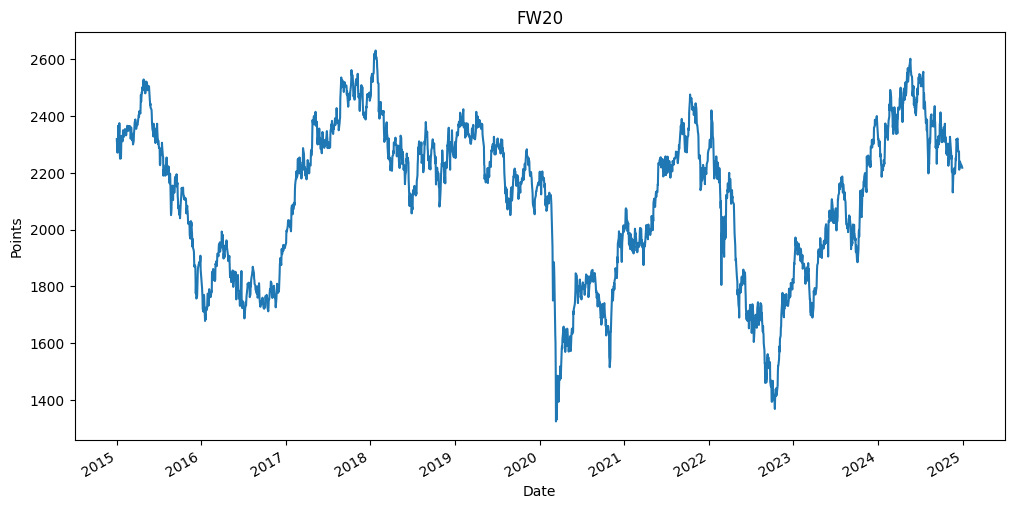

In [647]:
df['Close'].plot(title='FW20', figsize=(12, 6))
plt.ylabel('Points')

Text(0, 0.5, 'Average True Range (in Points)')

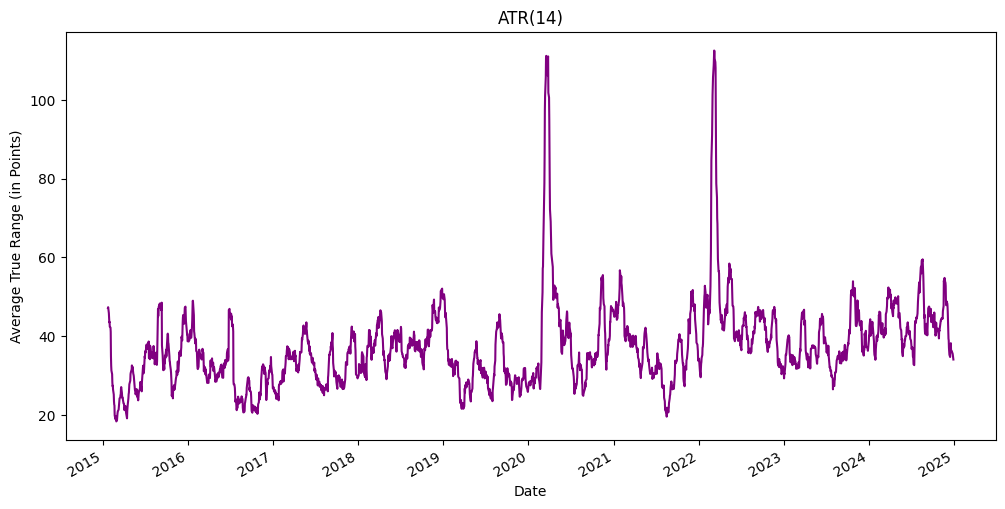

In [648]:
df['ATR_long'].plot(title=f"ATR({long_window})", figsize=(12, 6), color='purple')
plt.ylabel('Average True Range (in Points)')

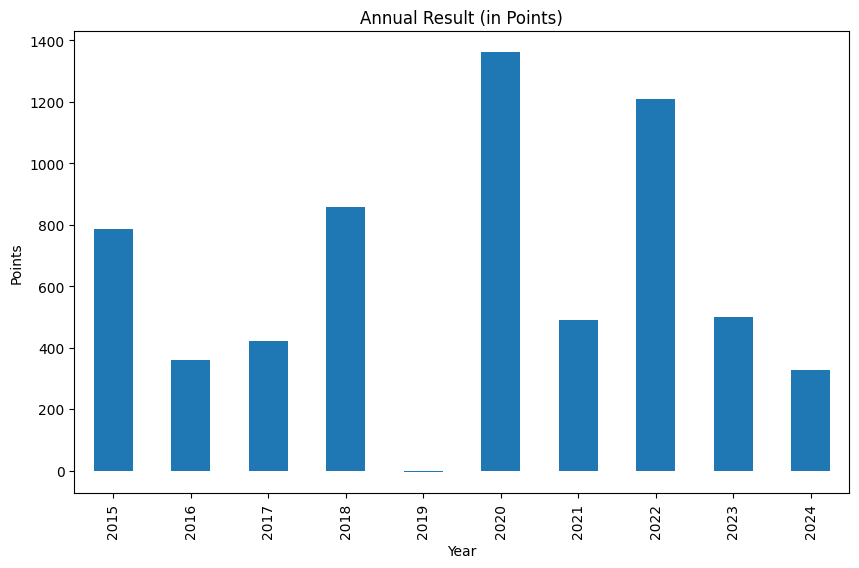

In [649]:
df['Daily_Pts'].groupby(df.index.year).sum().plot(kind='bar', title='Annual Result (in Points)', figsize=(10, 6))
plt.ylabel('Points')
plt.xlabel('Year')
plt.show()

In [650]:
df['Daily_Pts'].groupby(df.index.year).sum()

Date
2015     785.0
2016     359.0
2017     422.0
2018     858.0
2019      -6.0
2020    1360.0
2021     489.0
2022    1209.0
2023     501.0
2024     327.0
Name: Daily_Pts, dtype: float64

Text(0, 0.5, 'Cumulative Points')

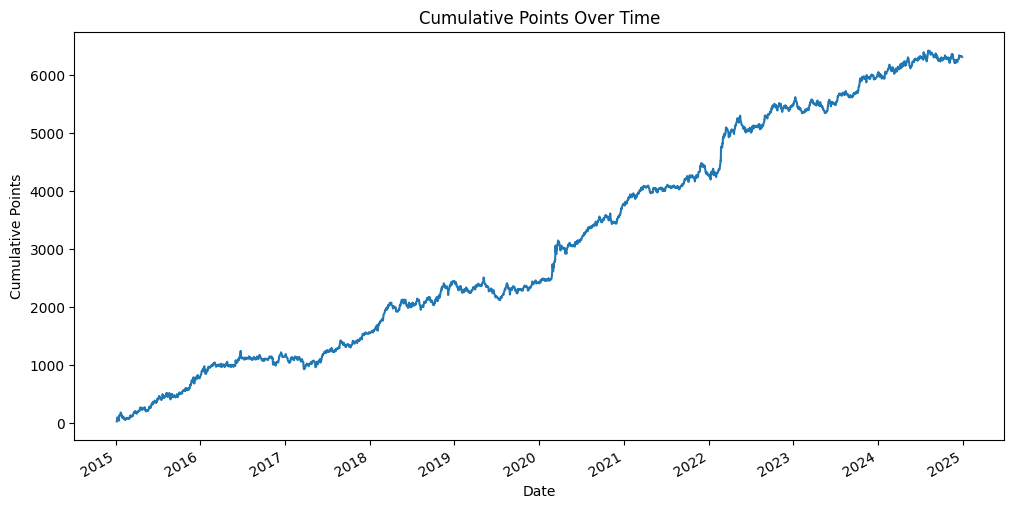

In [651]:
df['Cumulative_Pts'].plot(title='Cumulative Points Over Time', figsize=(12, 6))
plt.ylabel('Cumulative Points')

Text(0, 0.5, 'Capital (PLN)')

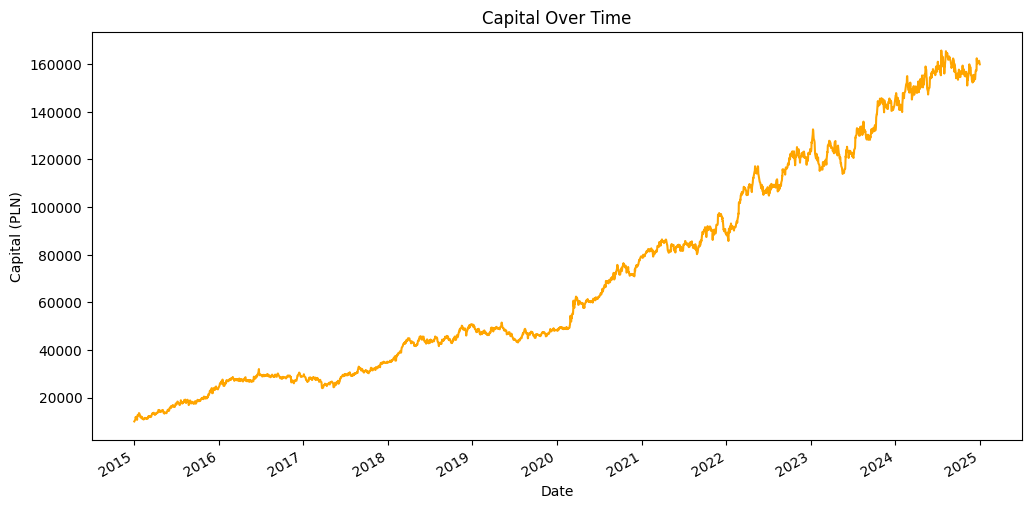

In [652]:
df['Capital'].plot(title='Capital Over Time', figsize=(12, 6), color='orange')
plt.ylabel('Capital (PLN)')

Text(0, 0.5, 'Drawdown (PLN)')

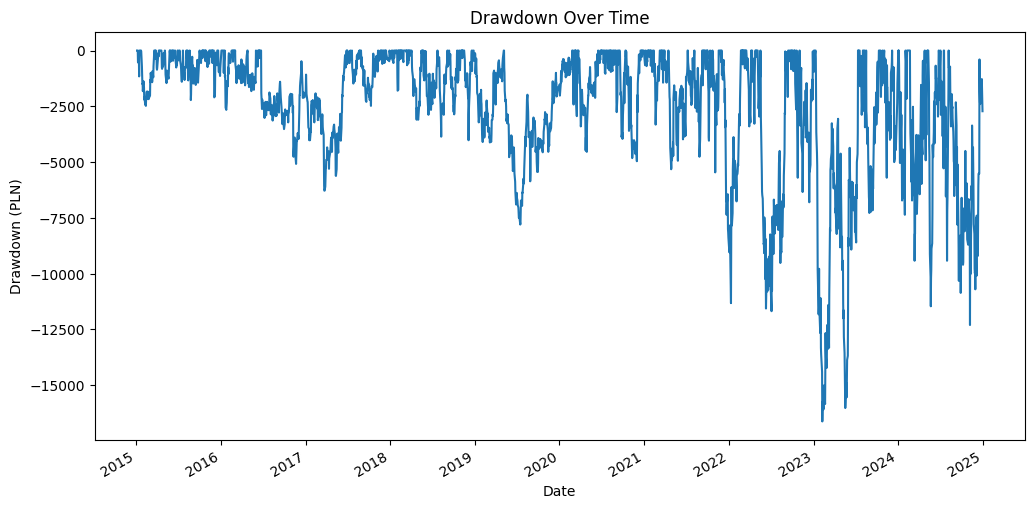

In [653]:
df['Drawdown'].plot(title='Drawdown Over Time', figsize=(12, 6))
plt.ylabel('Drawdown (PLN)')

Text(0, 0.5, 'Drawdown Percentage (%)')

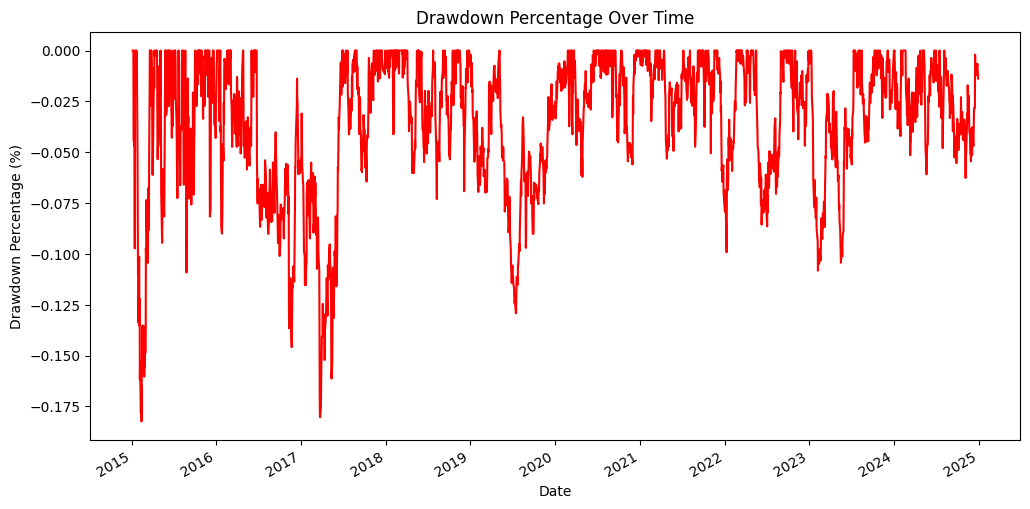

In [654]:
df['Drawdown_Pct'].plot(title='Drawdown Percentage Over Time', figsize=(12, 6), color='red')
plt.ylabel('Drawdown Percentage (%)')

Text(0, 0.5, 'Position Size')

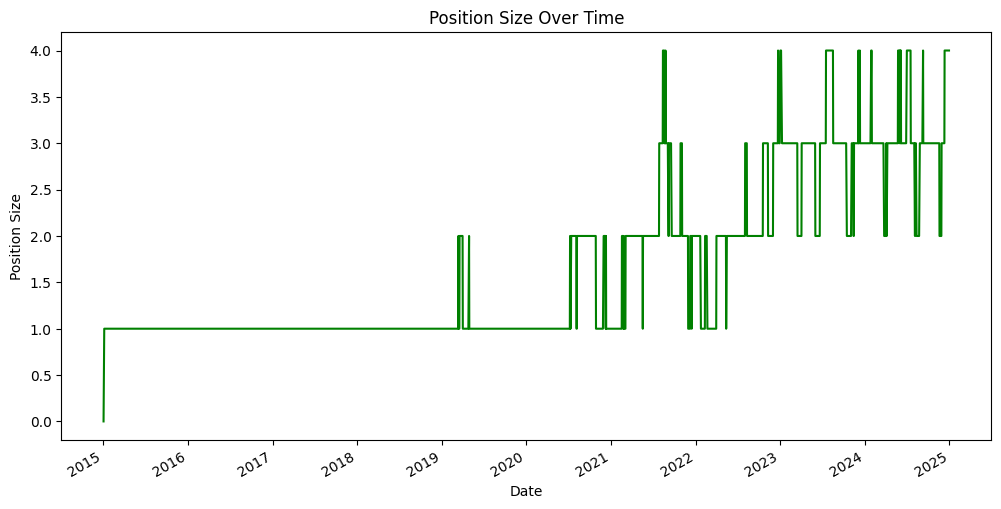

In [655]:
df['Position_Size'].plot(title='Position Size Over Time', figsize=(12, 6), color='green')
plt.ylabel('Position Size')

### Performance Metrics Calculation

In [656]:
trades = []
current_pos = 0
entry_price = None
entry_index = None
pnl = 0

for i in range(1, len(df)):
    row = df.iloc[i]
    prev_row = df.iloc[i - 1]

    # Entry
    if current_pos == 0 and row['Position'] != 0:
        current_pos = row['Position']
        entry_price = row['Entry_Price']
        entry_index = df.index[i]
        pnl = 0

    # Still in position
    elif current_pos != 0 and row['Position'] == current_pos:
        pnl += row['Daily_Pts']

    # Exit or flip
    elif current_pos != 0 and row['Position'] != current_pos:
        pnl += row['Daily_Pts']
        exit_index = df.index[i]
        trades.append({
            'Entry_Date': entry_index,
            'Exit_Date': exit_index,
            'Position': current_pos,
            'PnL': pnl
        })

        # Start new trade if flipped
        if row['Position'] != 0:
            current_pos = row['Position']
            entry_price = row['Entry_Price']
            entry_index = df.index[i]
            pnl = 0
        else:
            current_pos = 0
            entry_price = None
            entry_index = None
            pnl = 0

In [657]:
trades_df = pd.DataFrame(trades)

In [658]:
total_trades = len(trades_df)

# --- Basic Trade Statistics ---

# Subsets
winning_trades = trades_df[trades_df['PnL'] > 0]
losing_trades = trades_df[trades_df['PnL'] < 0]

# Counts
no_profitable_trades = len(winning_trades)
no_losing_trades = len(losing_trades)
winrate = no_profitable_trades / total_trades if total_trades > 0 else 0

# Calculate average profit per winning trade
avg_profit = winning_trades['PnL'].mean()

# Calculate average loss per losing trade
avg_loss = losing_trades['PnL'].mean()  # This will be negative

# Calculate payout ratio
if avg_loss != 0:
    payout_ratio = avg_profit / abs(avg_loss)
else:
    payout_ratio = np.nan  # Avoid division by zero

edge = (winrate * payout_ratio) - (1 - winrate)

# --- Risk-Adjusted Performance ---

daily_returns = df['Daily_PnL'] / df['Capital'].shift(1)
negative_returns = daily_returns[daily_returns < 0]

# Sharpe Ratio
sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

# Sortino Ratio
sortino = daily_returns.mean() / negative_returns.std() * np.sqrt(252)

# Drawdowns
max_dd = df['Drawdown'].min()
max_dd_pct = df['Drawdown_Pct'].min()
romad = df['Cumulative_PnL'].iloc[-1] / abs(max_dd) if max_dd != 0 else np.nan

gross_profit = winning_trades['PnL'].sum()
gross_loss = losing_trades['PnL'].sum()
expectancy = (winrate * avg_profit) + ((1 - winrate) * avg_loss)

holding_days = (trades_df['Exit_Date'] - trades_df['Entry_Date']).dt.days
avg_holding_period = holding_days.mean()




In [659]:
num_years = (df.index[-1] - df.index[0]).days / 365.25

final_capital = df['Capital'].iloc[-1]

if num_years > 0 and initial_capital > 0:
    cagr = (final_capital / initial_capital) ** (1 / num_years) - 1
else:
    cagr = np.nan



### Perofirmance Metrics

In [660]:
# Print results
print("Start date: ", start_date)
print("End date:", end_date)
print("-------------------")
print("Total Trades:", total_trades)
print("Profitable Trades:", no_profitable_trades)
print("Losing Trades:", no_losing_trades)
print("Win Rate:", round(no_profitable_trades / total_trades * 100, 2), "%")
print(f"Average Profit per Trade: {avg_profit:.2f}")
print(f"Average Loss per Trade: {avg_loss:.2f}")
print(f"Payout Ratio: {payout_ratio:.2f}")
print(f"Edge: {edge:.2f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max DD: {max_dd:.2f}")
print(f"Max DD %: {max_dd_pct*100:.2f}%")
print(f"RoMaD: {romad:.2f}")
print(f"Expectancy: {expectancy:.2f}")
print(f"Avg Holding Period: {avg_holding_period:.2f}")
print("-------------------")
print("Initial capital: ", initial_capital)
print("Final capital: ", final_capital)
print(f"CAGR: {cagr*100:.2f}%")

Start date:  2015-01-01
End date: 2024-12-31
-------------------
Total Trades: 1199
Profitable Trades: 580
Losing Trades: 600
Win Rate: 48.37 %
Average Profit per Trade: 32.09
Average Loss per Trade: -20.55
Payout Ratio: 1.56
Edge: 0.24
Sharpe Ratio: 1.61
Sortino Ratio: 2.61
Max DD: -16620.00
Max DD %: -18.24%
RoMaD: 11.65
Expectancy: 4.91
Avg Holding Period: 3.04
-------------------
Initial capital:  10000
Final capital:  159948.0
CAGR: 31.97%
